In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [31]:
# Read the dataset
file_path = 'C:/Users/Kimbe/Downloads/mental_health_data.xlsx'
print("Loading data...")
df = pd.read_excel(file_path)
df

Loading data...


,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,2014-08-27 11:29:00,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,2014-08-27 11:31:00,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,2014-08-27 11:32:00,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,2014-08-27 11:37:00,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,2014-08-27 11:43:00,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,2015-07-27 23:25:00,Male,United States,Business,Yes,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,Maybe,Not sure
292360,2015-08-17 09:38:00,Male,South Africa,Business,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes
292361,2015-08-25 19:59:00,Male,United States,Business,No,Yes,No,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,No
292362,2015-09-26 01:07:00,Male,United States,Business,No,Yes,Yes,15-30 days,No,Maybe,No,Low,Yes,No,Maybe,No,Yes


In [33]:
df = df[df['Country'] == 'United States'].copy()  # Filtering data
df.drop('Timestamp', axis=1, inplace=True)  # Removing the Timestamp column

In [34]:
# Encode categorical features
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

In [35]:
# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns)

In [38]:
# Normality Test (Anderson-Darling) with filtering
normality_results = []

for col in X_scaled_df.columns:
    if X_scaled_df[col].std() == 0:
        normality_results.append({'Feature': col, 'Normal (Anderson)': False})
        continue
    sample = X_scaled_df[col].sample(n=5000, random_state=42)
    result = anderson(sample)
    is_normal = result.statistic < result.critical_values[2]  # 5% level
    normality_results.append({'Feature': col, 'Normal (Anderson)': is_normal})

# Equal Variance Test (Levene's Test)
variance_results = []

for col1, col2 in combinations(X_scaled_df.columns, 2):
    stat, p = levene(X_scaled_df[col1], X_scaled_df[col2])
    variance_results.append({
        'Feature 1': col1,
        'Feature 2': col2,
        "Levene's p": p,
        'Equal Variance (p > 0.05)': p > 0.05
    })

variance_df = pd.DataFrame(variance_results)

# Optional: summary of variance test per feature
variance_summary = pd.concat([
    variance_df[['Feature 1', 'Equal Variance (p > 0.05)']].rename(columns={'Feature 1': 'Feature'}),
    variance_df[['Feature 2', 'Equal Variance (p > 0.05)']].rename(columns={'Feature 2': 'Feature'})
])
variance_summary = variance_summary.groupby('Feature')['Equal Variance (p > 0.05)'].apply(lambda x: f"{x.sum()}/{len(x)} passed").reset_index()

# Combine results
final_df = pd.merge(normality_df, variance_summary, on='Feature')

# Display results
print(final_df)

                    Feature  Normal (Anderson) Equal Variance (p > 0.05)
0                    Gender              False               0/15 passed
1                   Country              False               0/15 passed
2                Occupation              False               1/15 passed
3             self_employed              False               0/15 passed
4            family_history              False               0/15 passed
5                 treatment              False               0/15 passed
6              Days_Indoors              False               0/15 passed
7            Growing_Stress              False               0/15 passed
8            Changes_Habits              False               1/15 passed
9     Mental_Health_History              False               1/15 passed
10              Mood_Swings              False               0/15 passed
11         Coping_Struggles              False               0/15 passed
12            Work_Interest              False     

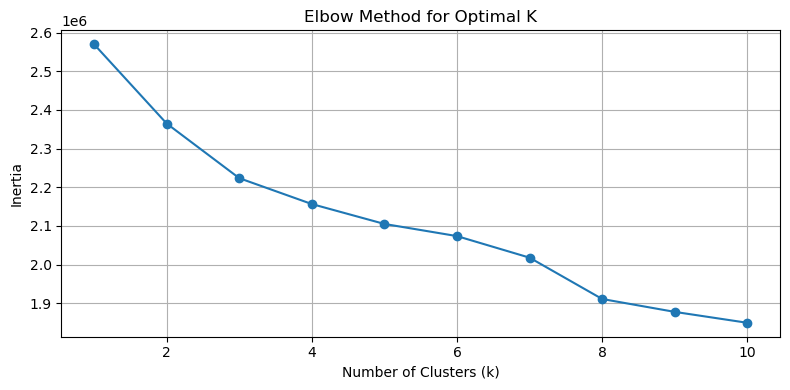

In [19]:
# Use inertia (within-cluster sum of squares) to find optimal k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.tight_layout()
plt.show()

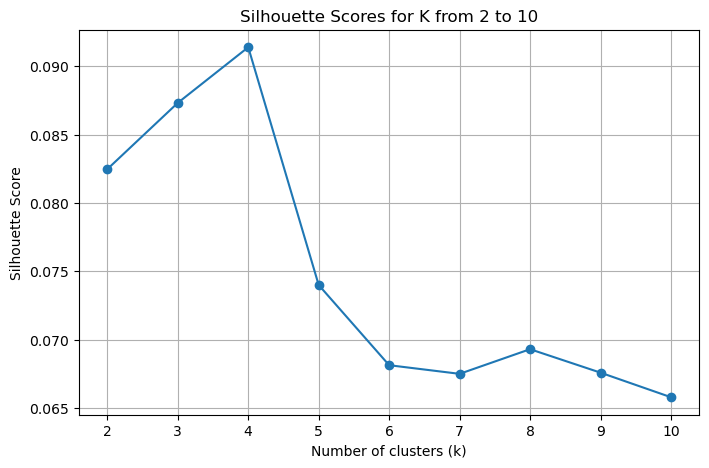

Silhouette Score for k=2: 0.0825
Silhouette Score for k=3: 0.0873
Silhouette Score for k=4: 0.0914
Silhouette Score for k=5: 0.0740
Silhouette Score for k=6: 0.0681
Silhouette Score for k=7: 0.0675
Silhouette Score for k=8: 0.0693
Silhouette Score for k=9: 0.0676
Silhouette Score for k=10: 0.0658


In [79]:
# Random sample of 3,000 rows
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), size=3000, replace=False)
X_sampled = X_scaled[sample_indices]

# Store silhouette scores
sil_scores = []

# Test k = 2 to 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_sampled)
    score = silhouette_score(X_sampled, labels)
    sil_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Scores for K from 2 to 10')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Print the numerical silhouette scores
for k, score in zip(range(2, 11), sil_scores):
    print(f"Silhouette Score for k={k}: {score:.4f}")

In [44]:
# Fit Final KMeans Model
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

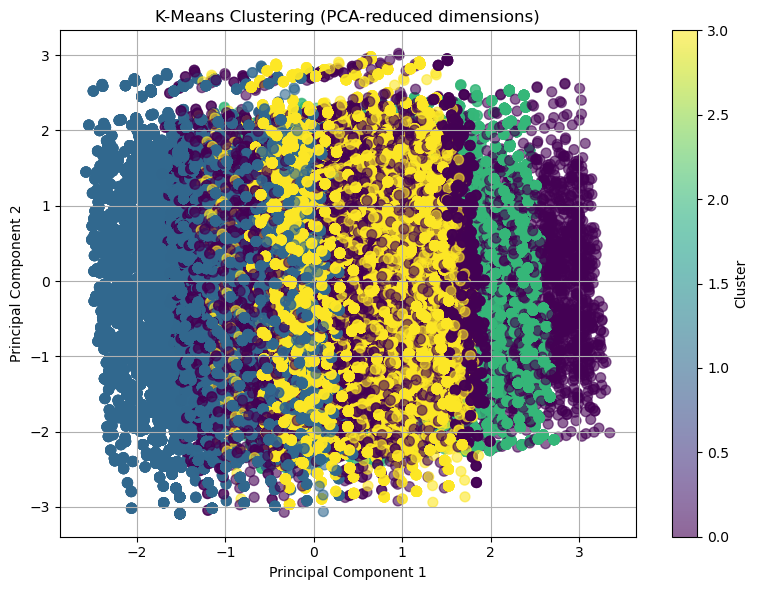

In [45]:
# Fit KMeans with the optimal number of clusters (let's assume k=4 based on your analysis)
k = 4  # Replace with the best k from silhouette score
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Create a scatter plot with the clusters colored differently
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
plt.title('K-Means Clustering (PCA-reduced dimensions)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Since data is not normal, use Kruskal Wallis instead of ANOVA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal, chi2_contingency

# ------------------------------------------
# Kruskal-Wallis Tests Across Clusters
# ------------------------------------------
features_to_test = ['Mood_Swings', 'Coping_Struggles', 'Mental_Health_History', 'treatment']
print("Kruskal-Wallis Tests Across Clusters:\n")

for feature in features_to_test:
    groups = [df[df['Cluster'] == k][feature] for k in sorted(df['Cluster'].unique())]
    stat, p = kruskal(*groups)
    print(f"{feature}: H = {stat:.3f}, p = {p:.4f}")

# ------------------------------------------
# Chi-squared Test for Treatment by Cluster
# ------------------------------------------
print("\nChi-squared Test for Treatment Rate across Clusters:")
contingency = pd.crosstab(df['Cluster'], df['treatment'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2 = {chi2:.3f}, p = {p:.4f}, dof = {dof}")
print("Contingency Table:\n", contingency)

Kruskal-Wallis Tests Across Clusters:

Mood_Swings: H = 40328.183, p = 0.0000
Coping_Struggles: H = 1677.851, p = 0.0000
Mental_Health_History: H = 9067.839, p = 0.0000
treatment: H = 77403.668, p = 0.0000

Chi-squared Test for Treatment Rate across Clusters:
Chi2 = 77404.120, p = 0.0000, dof = 3
Contingency Table:
 treatment      0      1
Cluster                
0           3168  47196
1          21234  16467
2          10137  25169
3          43737   4200


In [23]:
# Summarize Clusters (Profiles)
def summarize_cluster(group):
    summary = {}
    for col in group.columns:
        if col == 'Cluster':
            continue
        if group[col].dtype == 'object':
            summary[col] = group[col].mode()[0]
        else:
            summary[col] = round(group[col].mean(), 2)
    return pd.Series(summary)

cluster_summary = df.groupby('Cluster').apply(summarize_cluster)
print("Cluster Profiles:\n")
print(cluster_summary)

Cluster Profiles:

         Gender  Country  Occupation  self_employed  family_history  \
Cluster                                                               
0           1.0      0.0        1.75           0.12            0.70   
1           1.0      0.0        2.92           0.10            0.33   
2           0.0      0.0        2.12           0.10            0.59   
3           1.0      0.0        1.64           0.06            0.15   

         treatment  Days_Indoors  Growing_Stress  Changes_Habits  \
Cluster                                                            
0             0.94          1.90            1.02            1.18   
1             0.44          2.10            0.85            0.64   
2             0.71          2.03            1.10            1.04   
3             0.09          1.88            1.03            1.24   

         Mental_Health_History  Mood_Swings  Coping_Struggles  Work_Interest  \
Cluster                                                          

C:\Users\Kimbe\AppData\Local\Temp\ipykernel_24712\3081788063.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_summary = df.groupby('Cluster').apply(summarize_cluster)


In [83]:
# Derive Treatment Suggestions Based on 4 key features + treatment status
treatment_suggestions = {}

for cluster_num, row in cluster_summary.iterrows():
    mood = row['Mood_Swings']
    history = row['Mental_Health_History']
    coping = row['Coping_Struggles']
    treatment_rate = row['treatment']
    
    # High risk, but low treatment
    if mood > 1.2 and history > 1.0 and treatment_rate < 0.5:
        suggestion = 'CBT + Guided Access to Professional Care (Low Treatment Uptake)'
        
    # High risk, actively receiving treatment
    elif mood > 1.2 and history > 1.0 and treatment_rate >= 0.5:
        suggestion = 'Continue CBT + Psychiatric Support (Monitor Progress)'
        
    # Low history and mood, not in treatment
    elif history < 0.8 and mood < 0.6 and treatment_rate < 0.5:
        suggestion = 'Preventive Mental Health Education & Self-Help Resources'
        
    # High coping struggles and no to treatment
    elif coping > 0.6 and treatment_rate < 0.4:
        suggestion = 'Stress Management + Peer Support Introduction (Encourage Treatment)'
        
    # Moderate all around, already receiving help
    elif 0.8 <= mood <= 1.1 and 0.9 <= history <= 1.1 and treatment_rate >= 0.5:
        suggestion = 'Continue General Therapy + Optional Group Counseling'
        
    # Default fallback
    else:
        suggestion = 'General Counseling & Annual Mental Health Check-In'

    treatment_suggestions[cluster_num] = suggestion

In [84]:
# Assign Treatment Suggestions to Each Participant
df['treatment_suggestion'] = df['Cluster'].map(treatment_suggestions)

In [85]:
# Display Final Cluster Summary and Suggestions
print("\nTreatment Suggestions by Cluster:\n", treatment_suggestions)


Treatment Suggestions by Cluster:
 {0: 'Continue CBT + Psychiatric Support (Monitor Progress)', 1: 'Preventive Mental Health Education & Self-Help Resources', 2: 'Continue General Therapy + Optional Group Counseling', 3: 'CBT + Guided Access to Professional Care (Low Treatment Uptake)'}
